# Regression with ParmEst

In [1]:
# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import TCLabExperiment, create_model, extract_results, extract_plot_results

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data

In [2]:
import pandas as pd
file = '../data/tclab_sine_test.csv'
# file = './data/tclab_step_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


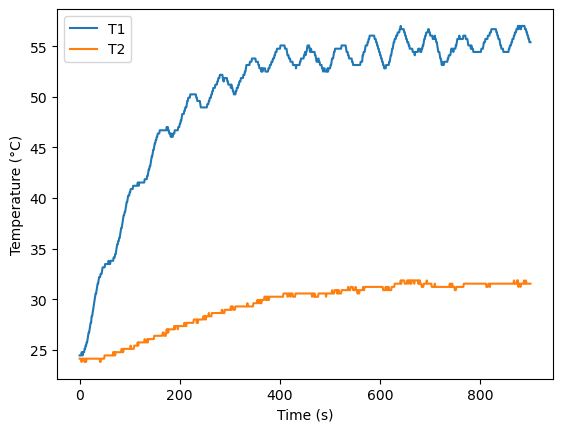

In [3]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

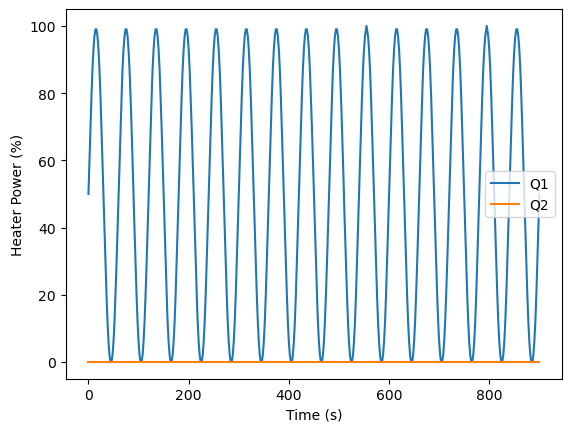

In [4]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

## Store in Custom Data Class 

In [5]:
tc_data = TCLabExperiment(name="Sine Wave Test for Heater 1",
                            time=df['Time'].values,
                            T1=df['T1'].values,
                            u1=df['Q1'].values,
                            P1=200,
                            TS1_data=None,
                            d1 = None,
                            T2=df['T2'].values,
                            u2=df['Q2'].values,
                            P2=200,
                            TS2_data=None,
                            d2 = None,
                            Tamb=df['T1'].values[0])

In [6]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,d1,T2,u2,P2,TS2_data,d2,Tamb
0,0.00,24.45,50.0,200,None,None,24.13,0.0,200,None,None,24.45
1,1.00,24.45,55.0,200,None,None,24.13,0.0,200,None,None,24.45
2,2.01,24.45,60.0,200,None,None,24.13,0.0,200,None,None,24.45
3,3.01,24.45,65.0,200,None,None,24.13,0.0,200,None,None,24.45
4,4.01,24.77,70.0,200,None,None,23.81,0.0,200,None,None,24.45


## Paramter Estimation in Vanilla Pyomo

In [7]:
from pyomo.environ import SolverFactory

vanilla_regression = create_model(data=tc_data.to_data_frame(), mode='estimate', model_option='parmest', integrate_to_initialize=True, number_of_states=number_tclab_states)

# Alternatively, you can use the TCLabExperiment object directly
#vanilla_regression = create_model(data=tc_data, mode='estimate', model_option='parmest', integrate_to_initialize=True)

# Optionally explore the model structure
#vanilla_regression.pprint()

# Solve the regression problem
solver = SolverFactory('ipopt')
results = solver.solve(vanilla_regression, tee=True)


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

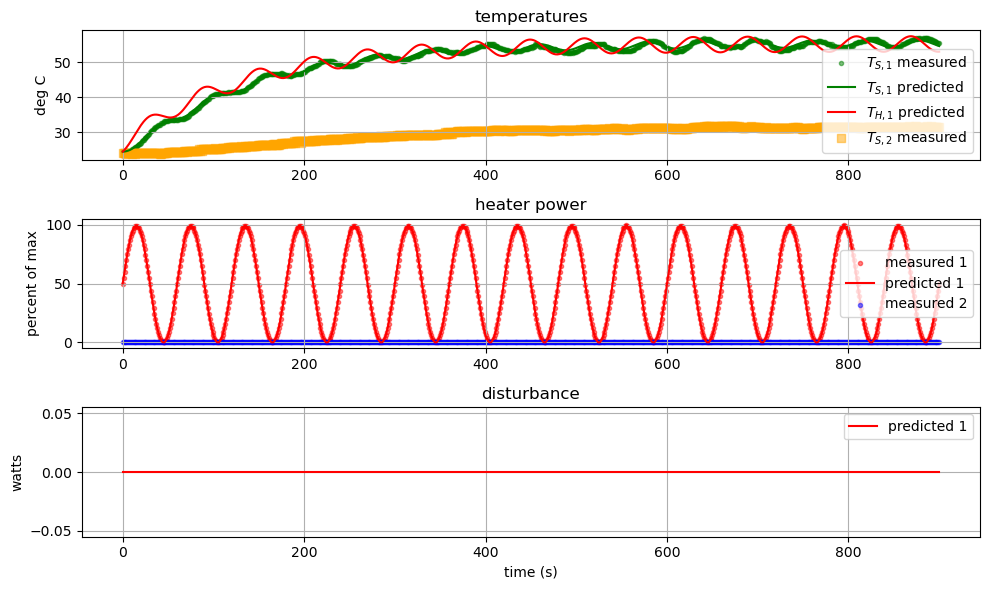

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC


In [8]:
vanilla_regression_results = extract_plot_results(tc_data, vanilla_regression)

## Parameter Estimation with ParmEst

In [9]:
import pyomo.contrib.parmest.parmest as parmest

# define the parameter names as a list
if number_tclab_states == 2:
    theta_names = ['Ua', 'Ub', 'inv_CpH', 'inv_CpS']
else:
    theta_names = ['Ua', 'Ub', 'Uc','inv_CpH', 'inv_CpS']

parmest_create_model = lambda data: create_model(data=data, mode='parmest', model_option='parmest', integrate_to_initialize=True, number_of_states=number_tclab_states)

# Create a parameter estimation object
pest = parmest.Estimator(parmest_create_model,
                         data=[tc_data.to_data_frame()], # Needs to be a list of dataframes, otherwise parmest threats each row as a separate model
                         theta_names=theta_names,
                         tee=True)

obj, theta = pest.theta_est()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

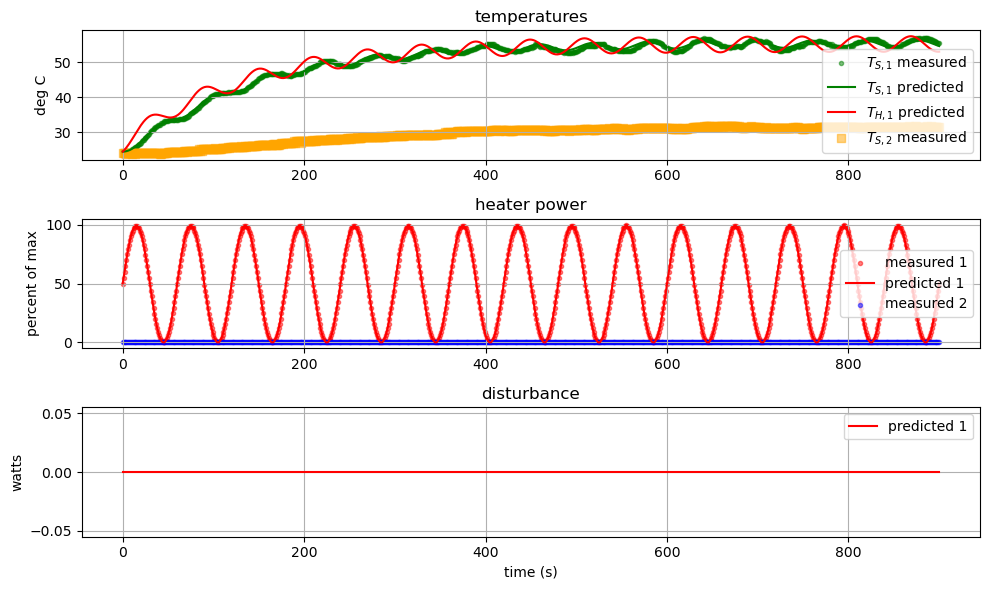

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC


In [10]:
parmest_regression_results = extract_plot_results(tc_data, pest.parmest_model)

In [14]:
theta_values = theta.to_dict()
print("Estimated parameters:\n",theta_values)

Estimated parameters:
 {'Ua': 0.05147278733764012, 'Ub': 0.0005342082856927798, 'inv_CpH': 0.14622879403418604, 'inv_CpS': 99.99999754623846}


## Covariance Matrix

In [11]:
# Estimate the covariance matrix
obj, theta, cov = pest.theta_est(calc_cov=True, # boolean to calculate the covariance matrix
                                                  cov_n = len(tc_data.time) # number of data points in the least squares objective
                                                  )

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

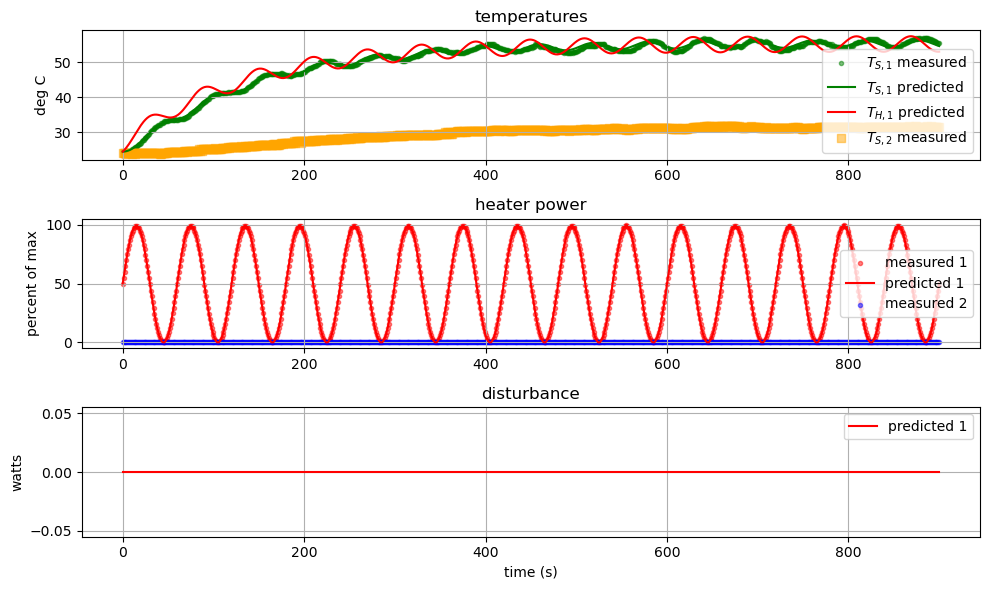

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC


In [12]:
parmest_regression_results2 = extract_plot_results(tc_data, pest.parmest_model)

In [13]:
print(cov)

                   Ua            Ub       inv_CpH       inv_CpS
Ua       2.205182e-09 -2.420538e-10  2.275436e-08  7.737639e-13
Ub      -2.420538e-10  2.073777e-10 -1.036322e-08  6.894656e-09
inv_CpH  2.275436e-08 -1.036322e-08  7.628117e-07  3.246808e-09
inv_CpS  7.737639e-13  6.894656e-09  3.246808e-09 -1.292939e-03
